# Banana classification example following "StationaryActivations..." paper

## Imports

In [72]:
# !pip install tqdm

In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import logging

# set up logging to file
logging.basicConfig(
     level=logging.INFO, 
     format= '[%(asctime)s] {%(pathname)s:%(lineno)d} %(levelname)s - %(message)s',
     datefmt='%H:%M:%S'
 )

In [74]:
import json
import datetime
import os

from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [75]:
import gpytorch

from gpytorch.models import AbstractVariationalGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from gpytorch.mlls.variational_elbo import VariationalELBO

In [76]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import MCMC, NUTS
from pyro.infer import Predictive

In [77]:
import sys
sys.path.append("../")

import import_export
from examples import configs
import activations

from train_priors_and_activations import main_parameterized as train_priors_and_activations
import metrics

## Config

In [80]:
# (Variational) GP:
target_gp_config_set_no = -111
gp_optimize_hyperparameters = False  # if false only variational params are optimized


# test grid:
gridwidth = 100  #number of test samples in each dimension  
gridlength = 3.75  #how far to extend the test samples around 0 in both dimensions


# HMC posterior
MCMC_n_samples = 1000
MCMC_n_chains = 1

bnn_net_width = 1000


# Plotting
plot_predictive_n_samples = 1000

In [81]:
priors = "train" 
# priors = "default_with_relu"
# priors = "normal_with_relu"

# prior learning
train_input_n_dims = 2
train_n_iterations = 3001
train_num_function_samples = 512
train_batch_size = 512
train_activation = "nnsilu_1_5"

## Init

In [82]:
target_dir = f"../pretrained/e2e_twomoons_2D_classification_{priors}_{train_input_n_dims}D_" + datetime.datetime.now().strftime("%Y%m%d%H%M%S")
results_prefix = target_dir + "/"

print(f"Saving results to target_dir = {target_dir}")

if target_dir is not None and target_dir != "":
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

Saving results to target_dir = ../results/gp_vs_bnn_classification_test_banana_20240903202923


In [83]:
# Set GP kernel:

generator, meta, data_min_x, data_max_x = configs.get_configs(config_set_no=target_gp_config_set_no)
kernel = generator.kernel

## Load and preprocess data.

In [84]:
# !rm *.csv
# !mkdir ../data/
# !wget https://raw.githubusercontent.com/AaltoML/stationary-activations/main/data/datapoints.csv 
# !mv datapoints.csv ../data/
# !wget https://raw.githubusercontent.com/AaltoML/stationary-activations/main/data/classes.csv 
# !mv classes.csv ../data/

In [85]:
# Download data from .csv files
data = pd.read_csv("../data/datapoints.csv", header = None) #2D points
data.columns = [f"col{c}" for c in data.columns]

classes = pd.read_csv("../data/classes.csv", header = None) #class labels
classes.columns = [f"col{c}" for c in classes.columns]

N_samples = len(classes) #Number of training samples

# Data to numpy arrays
data_array = np.zeros((N_samples,2))
data_array[:,0] = np.asarray(data.col0[:])
data_array[:,1] = np.asarray(data.col1[:])
class_array = np.asarray(classes.col0)

# Data to torch tensors for training
training_data = torch.from_numpy(data_array).float()
training_targets = torch.from_numpy(class_array).long()

In [86]:

x_vals = np.linspace(-gridlength,gridlength,gridwidth)
y_vals = np.linspace(-gridlength,gridlength,gridwidth)
grid_samples = np.zeros((gridwidth*gridwidth,2))
for i in range(gridwidth):
    for j in range(gridwidth):
        grid_samples[i*gridwidth + j, 0] = x_vals[i]
        grid_samples[i*gridwidth + j, 1] = y_vals[j]

grid_set = torch.from_numpy(grid_samples).float() #Grid samples to torch tensor

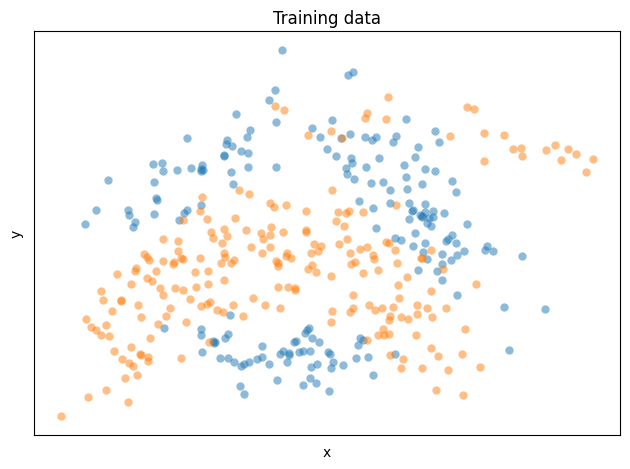

In [87]:
xv, yv = np.meshgrid(x_vals, y_vals) #Sample grid as a meshgrid

fig, ax = plt.subplots()
ax.set_title('Training data')
ax.plot(data_array[class_array==0,0], data_array[class_array==0,1], 'oC0', mew=0, alpha=0.5)
ax.plot(data_array[class_array==1,0], data_array[class_array==1,1], 'oC1', mew=0, alpha=0.5)
ax.grid(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([], [])
ax.set_yticks([], [])
ax.set_xlabel('x')
ax.set_ylabel('y')

fig.tight_layout() 

In [88]:
train_x = training_data
train_y = training_targets

## Aux

In [89]:
def set_style(ax1):
    ax1.grid(False)
    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    ax1.set_xticks([], [])
    ax1.set_yticks([], [])
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    
    
def plot_grid(ax, vals, vmax=1.0, contour=False, cmap='bwr_r'):
    im = ax.imshow(vals, cmap=cmap, #cmap='gray_r', 
                   extent=[-gridlength, gridlength, -gridlength, gridlength], 
                    origin='lower', alpha=0.5, vmin=0, vmax=vmax)
    ax.scatter(data_array[class_array==0,0], data_array[class_array==0,1], c='red', s=10, alpha=0.5)
    ax.scatter(data_array[class_array==1,0], data_array[class_array==1,1], c='dodgerblue', s=10, alpha=1.0)
    if contour:
        ax.contour(xv, yv, vals, [0.5], colors='k')
    return im


def plot_predictive_bernoulli(p_values, 
                              means_title="Predictive Expectations E[p]", 
                              stds_title='Predictive Std[p]',
                              means_label='E[p]',
                              stds_label='Std[p]',
                              title=None
                              ):
    exp_p = p_values.mean(axis=0)  # =E[y] https://en.wikipedia.org/wiki/Law_of_total_expectation
    std_p = p_values.std(axis=0)
    
    std_exp_y_cond_p = p_values.std(axis=0) 
    var_exp_y_cond_p = std_exp_y_cond_p**2  # Var[E[y|p]]
    
    exp_var_y_cond_p = ( p_values*(1.-p_values) ).mean(axis=0)  # E[Var[y|p]]
    exp_std_y_cond_p = np.sqrt(exp_var_y_cond_p+1e-12) 
    
    var_y = exp_var_y_cond_p + var_exp_y_cond_p  #https://en.wikipedia.org/wiki/Law_of_total_variance 
    std_y = np.sqrt(var_y+1e-12)
        
    exp_p = exp_p.reshape(gridwidth, gridwidth).T
    std_p = std_p.reshape(gridwidth, gridwidth).T
    std_exp_y_cond_p = std_exp_y_cond_p.reshape(gridwidth, gridwidth).T
    exp_std_y_cond_p = exp_std_y_cond_p.reshape(gridwidth, gridwidth).T
    std_y = std_y.reshape(gridwidth, gridwidth).T
    
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 8))
    if title: 
        plt.suptitle(title)
        
    file_prefix = results_prefix + (title or "fig")
    file_prefix = file_prefix.lower().replace(" ", "_").replace(":", "-")

    ax = axes[0, 0]
    im = plot_grid(ax, exp_p, vmax=1.0, contour=True, cmap='bwr_r')
    fig.colorbar(im, label="E[y] (=E[p])", ax=ax)    
    set_style(ax)
    ax.set_title("Predictive E[y] (=E[p])")
    
    ax = axes[0, 1]
    im = plot_grid(ax, np.sqrt(exp_p*(1-exp_p)+1e-12), vmax=0.5, contour=False, cmap='hot')
    fig.colorbar(im, label="Std(E[y])", ax=ax)    
    set_style(ax)    
    ax.set_title("Predictive Std(E[y])")
    
    ax = axes[0, 2]
    im = plot_grid(ax, std_p, vmax=0.5, contour=False, cmap='hot')
    fig.colorbar(im, ax=ax, label="Std[p]")
    set_style(ax)
    ax.set_title("Predictive Std[p]")    
    
    ax = axes[1, 2]
    im = plot_grid(ax, std_exp_y_cond_p, vmax=0.5, contour=False, cmap='hot')
    fig.colorbar(im, ax=ax, label="Std[E[y|p]]")
    set_style(ax)    
    ax.set_title("Predictive Std[E[y|p]]")    
    
    ax = axes[1, 1]
    im = plot_grid(ax, exp_std_y_cond_p, vmax=0.5, contour=False, cmap='hot')
    fig.colorbar(im, ax=ax, label="E[Std[y|p]]")
    set_style(ax)    
    ax.set_title("Predictive E[Std[y|p]]")    

    ax = axes[1, 0]
    im = plot_grid(ax, std_y, vmax=0.5, contour=False, cmap='hot')
    fig.colorbar(im, ax=ax, label="Std[y]")
    set_style(ax)    
    ax.set_title("Std[y] (=sqrt( E[Var[y|p]] + Var[E[y|p]]) )")    

    fig.savefig(file_prefix+".pdf")    

    fig.tight_layout() 

In [90]:
def report(line, verbose=True):
    if verbose:
        print(line)
    
    line = line.replace("\n", "\\ ")
    with open(results_prefix+"e2e_results.txt", "a") as results:
        results.write(line+"\n")    
        
def report_metric(name, value, **kwargs):
    report(str(name)+" = "+str(value), **kwargs)    

In [91]:
print("Reporting configurations...")

variables = locals().copy()
for name, value in variables.items():
    if hasattr(value, "shape"):
        value = value.shape    
    value = str(value)
    if name.startswith("_") or value.startswith("<"):
        continue
    if len(str(value))>200:
        value = value[:200]
    report_metric(name, value, verbose=False)

Reporting configurations...


## Variational GP learning: Ground-truth solution

In [92]:
class GPClassificationModel(AbstractVariationalGP):
    
    def __init__(self, train_x, 
                 mean_module = gpytorch.means.ConstantMean(), 
                 kernel=gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())):
        
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        # variational_distribution = gpytorch.variational.NaturalVariationalDistribution(train_x.size(0))
        
        variational_strategy = VariationalStrategy(self, train_x, variational_distribution)
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
gp_model = GPClassificationModel(train_x, kernel=kernel)
likelihood = gpytorch.likelihoods.BernoulliLikelihood()


In [93]:
report(f"GP kernel = {kernel}")
report(f"GP parameters = {list((n, p.shape) for n, p in gp_model.named_parameters())}")

GP kernel = MaternKernel(
  (raw_lengthscale_constraint): Interval(1.000E+00, 1.000E+00)
)
GP parameters = [('variational_strategy.inducing_points', torch.Size([400, 2])), ('variational_strategy._variational_distribution.variational_mean', torch.Size([400])), ('variational_strategy._variational_distribution.chol_variational_covar', torch.Size([400, 400])), ('mean_module.raw_constant', torch.Size([])), ('covar_module.raw_lengthscale', torch.Size([1, 1]))]


NOTE: Predictive variance in likelihoods is just = p*(1-p). Number of discrepancies: 0


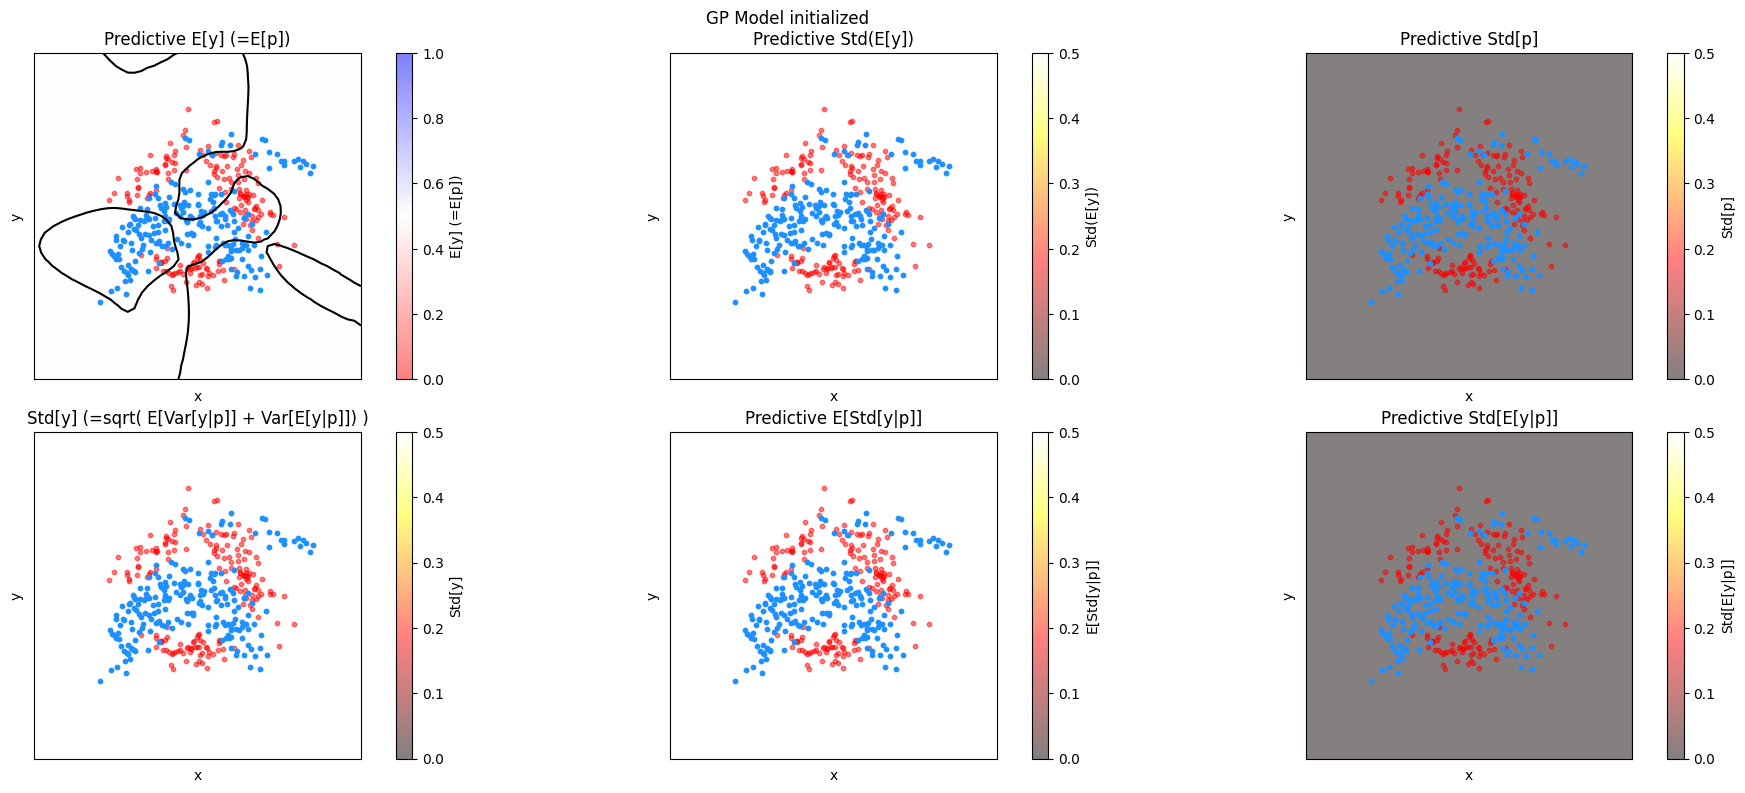

In [94]:
# Go into eval mode
gp_model.eval()
likelihood.eval()

n_discrepancies = sum(likelihood(gp_model(grid_set)).mean*(1-likelihood(gp_model(grid_set)).mean) != likelihood(gp_model(grid_set)).variance)
print(f"NOTE: Predictive variance in likelihoods is just = p*(1-p). Number of discrepancies: {n_discrepancies}" )

MC = 100
with torch.no_grad():
    # Get classification predictions
    observed_pred = torch.stack([likelihood(gp_model(grid_set)).mean for _ in range(MC)])

plot_predictive_bernoulli(observed_pred.numpy(), title="GP Model initialized"); plt.show()

In [95]:
gp_model.eval()
likelihood.eval()

total_NLL = -likelihood(gp_model(train_x)).log_prob(torch.tensor(train_y, dtype=train_x.dtype)).sum()
report(f"GP prior total NLL = {total_NLL}")

GP prior total NLL = 277.31744384765625


/var/folders/hp/hs3z_y8d7jx9n5m6m4yqp3zm0000gp/T/ipykernel_73303/3307882217.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_NLL = -likelihood(gp_model(train_x)).log_prob(torch.tensor(train_y, dtype=train_x.dtype)).sum()


In [96]:
# Optimize kernel hyperparams via marginal likelihood

if gp_optimize_hyperparameters:
    trained_params = {n: p for n, p in gp_model.named_parameters()}  # optimize all parameters
else:
    trained_params = {n: p for n, p in gp_model.named_parameters() if "variational" in n}  # optimize variational parameters only

trained_params_str = "\n - ".join( trained_params.keys())
print(f"Optimizing GP hyperparameters:\n - {trained_params_str}")


Optimizing GP hyperparameters:
 - variational_strategy.inducing_points
 - variational_strategy._variational_distribution.variational_mean
 - variational_strategy._variational_distribution.chol_variational_covar


In [97]:

# Find optimal model hyperparameters
gp_model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(trained_params.values(), lr=0.01)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the amount of training data
mll = VariationalELBO(likelihood, gp_model, train_y.numel())

training_iter = 200
for i in range(training_iter):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = gp_model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    
    train_bce = likelihood(gp_model(train_x)).log_prob(torch.tensor(train_y, dtype=torch.float)).exp().mean()
    print('Iter %d/%d - Loss: %.3f - data mean prob: :%.3f' % (i + 1, training_iter, loss.item(), train_bce.item()))
    optimizer.step()


Iter 1/200 - Loss: 1.001 - data mean prob: :0.500


/var/folders/hp/hs3z_y8d7jx9n5m6m4yqp3zm0000gp/T/ipykernel_73303/1189829130.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_bce = likelihood(gp_model(train_x)).log_prob(torch.tensor(train_y, dtype=torch.float)).exp().mean()


Iter 2/200 - Loss: 0.974 - data mean prob: :0.503
Iter 3/200 - Loss: 0.944 - data mean prob: :0.506
Iter 4/200 - Loss: 0.917 - data mean prob: :0.509
Iter 5/200 - Loss: 0.894 - data mean prob: :0.513
Iter 6/200 - Loss: 0.870 - data mean prob: :0.516
Iter 7/200 - Loss: 0.847 - data mean prob: :0.520
Iter 8/200 - Loss: 0.826 - data mean prob: :0.524
Iter 9/200 - Loss: 0.808 - data mean prob: :0.529
Iter 10/200 - Loss: 0.790 - data mean prob: :0.533
Iter 11/200 - Loss: 0.773 - data mean prob: :0.538
Iter 12/200 - Loss: 0.756 - data mean prob: :0.542
Iter 13/200 - Loss: 0.741 - data mean prob: :0.547
Iter 14/200 - Loss: 0.727 - data mean prob: :0.552
Iter 15/200 - Loss: 0.713 - data mean prob: :0.557
Iter 16/200 - Loss: 0.700 - data mean prob: :0.562
Iter 17/200 - Loss: 0.687 - data mean prob: :0.568
Iter 18/200 - Loss: 0.674 - data mean prob: :0.573
Iter 19/200 - Loss: 0.663 - data mean prob: :0.579
Iter 20/200 - Loss: 0.651 - data mean prob: :0.584
Iter 21/200 - Loss: 0.640 - data mean p

In [98]:
def sample_predictive_bernoulli_variational_gp(gp_model, input_x, n_samples=100):

    # Get posterior distribution of the latent function
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        latent_pred = gp_model(input_x)
        
        mean = latent_pred.mean
        variance = latent_pred.variance
        samples = torch.distributions.Normal(mean, variance.sqrt()).sample(torch.Size([n_samples]))

        # Apply sigmoid to transform to [0,1] interval representing probability p
        p_samples = torch.sigmoid(samples)
    return p_samples

In [99]:
# Go into eval mode
gp_model.eval()
likelihood.eval()

BernoulliLikelihood(
  (quadrature): GaussHermiteQuadrature1D()
)

NOTE: Predictive variance in likelihoods is just = p*(1-p). Number of discrepancies: tensor(0)


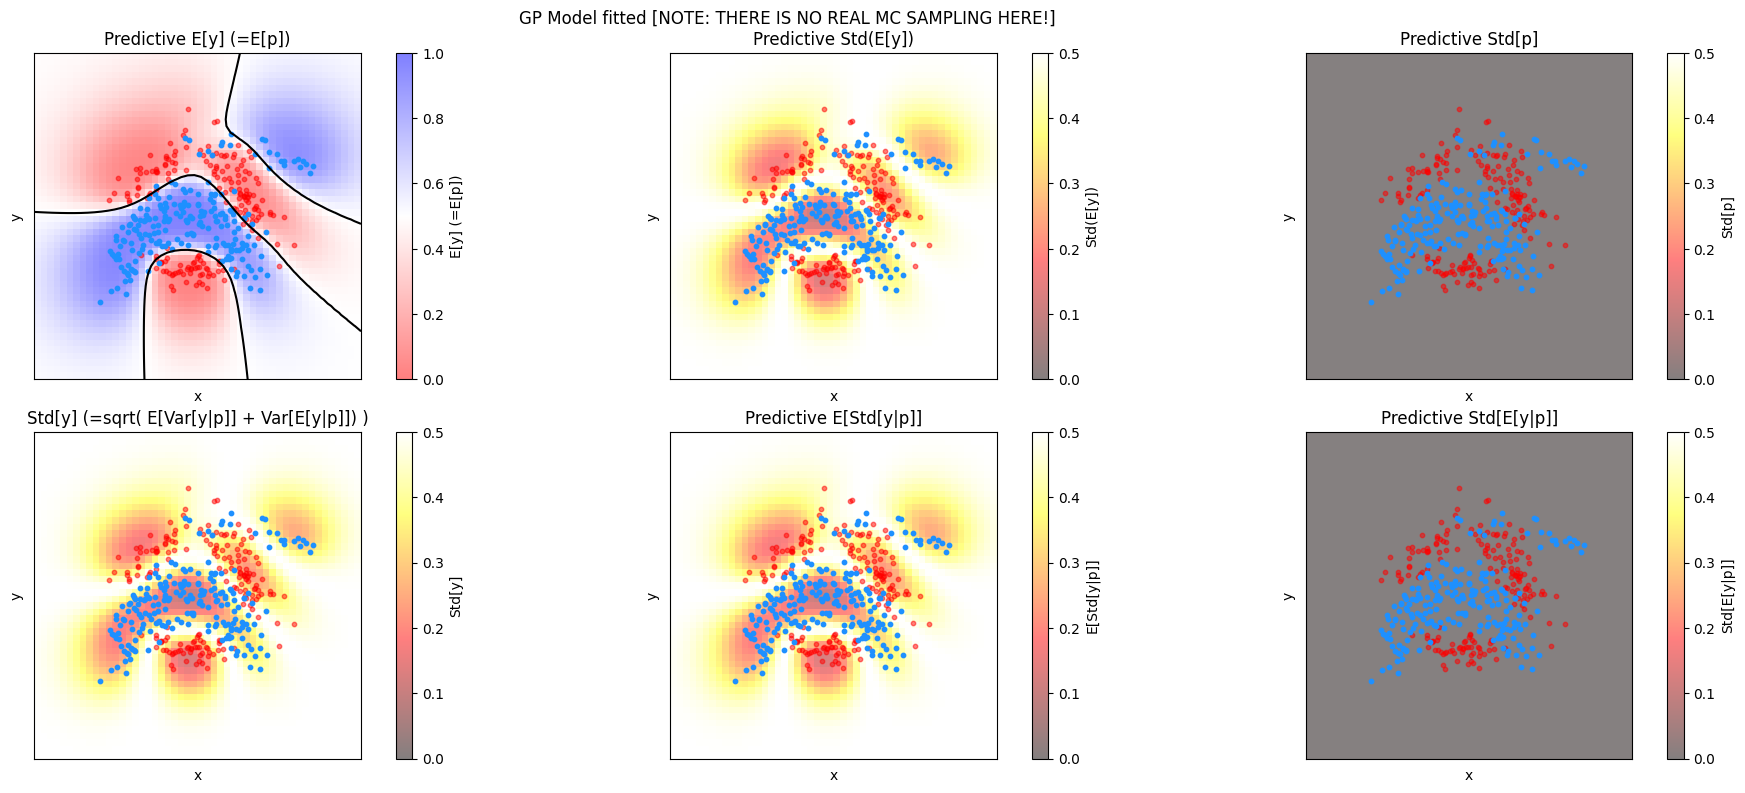

GP posterior total NLL (for mean p) = 94.97701263427734


/var/folders/hp/hs3z_y8d7jx9n5m6m4yqp3zm0000gp/T/ipykernel_73303/3102217741.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  NLL = -likelihood(gp_model(train_x)).log_prob(torch.tensor(train_y, dtype=train_x.dtype)).sum()


In [100]:
print("NOTE: Predictive variance in likelihoods is just = p*(1-p). Number of discrepancies:",
      sum(likelihood(gp_model(grid_set)).mean*(1-likelihood(gp_model(grid_set)).mean) != likelihood(gp_model(grid_set)).variance))

MC = 10
with torch.no_grad():
    # Get classification predictions
    observed_pred = torch.stack([likelihood(gp_model(grid_set)).mean for _ in range(MC)])

plot_predictive_bernoulli(observed_pred.numpy(), title="GP Model fitted [NOTE: THERE IS NO REAL MC SAMPLING HERE!]"); plt.show()


NLL = -likelihood(gp_model(train_x)).log_prob(torch.tensor(train_y, dtype=train_x.dtype)).sum()
report(f"GP posterior total NLL (for mean p) = {NLL}")

GP posterior total NLL (123 MC samples) = 133.22708129882812


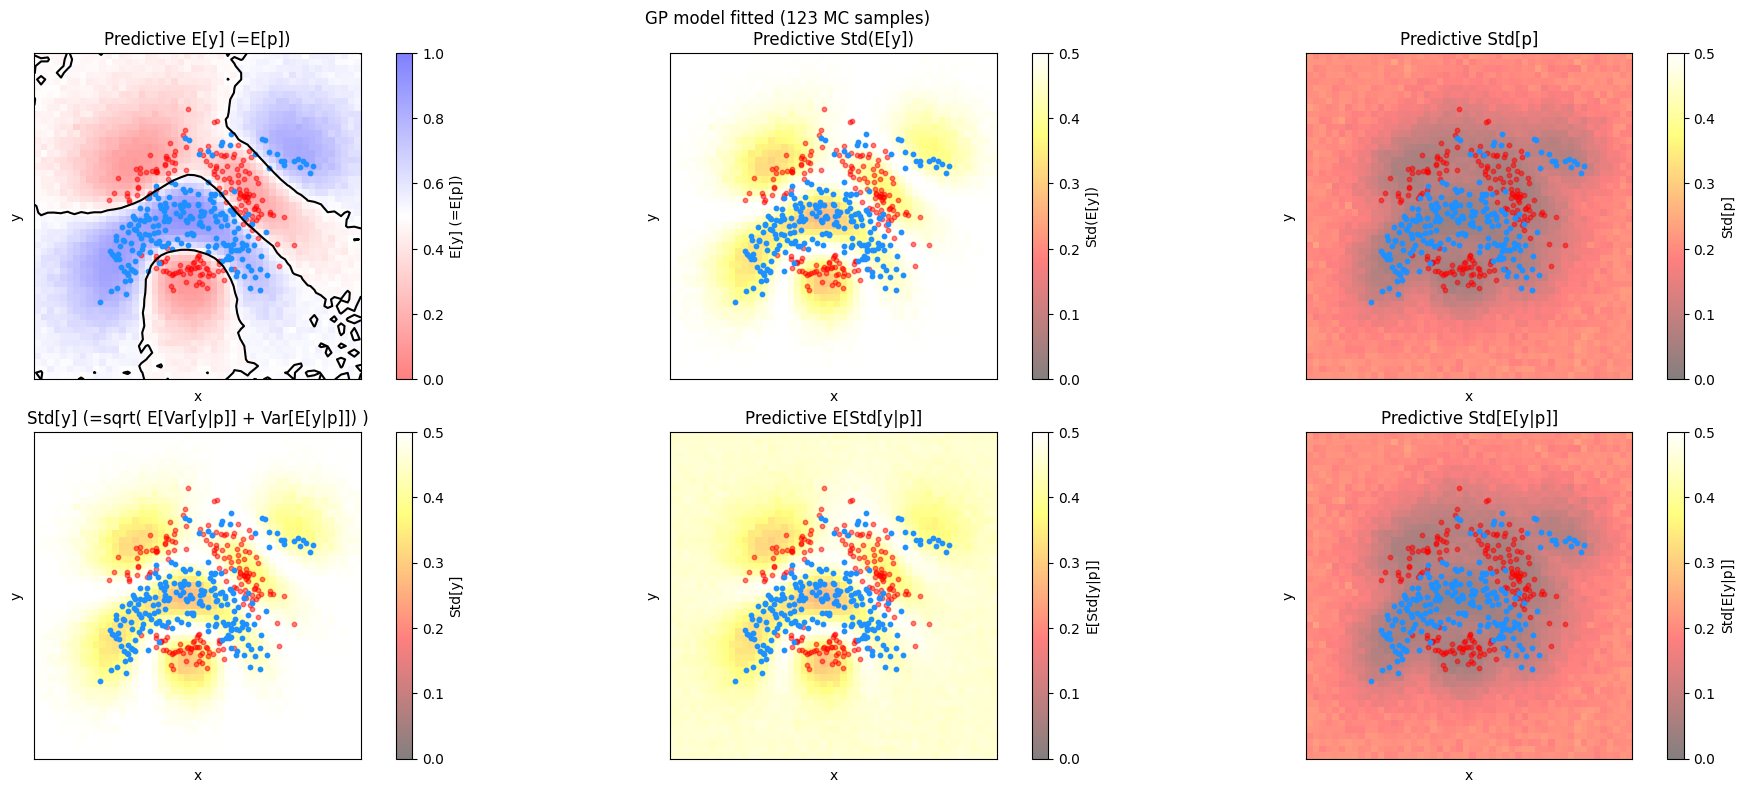

In [101]:
gp_p_samples_for_eval = p_samples = sample_predictive_bernoulli_variational_gp(gp_model, grid_set, plot_predictive_n_samples)
plot_predictive_bernoulli(p_samples, title=f"GP model fitted ({plot_predictive_n_samples} MC samples)")

y = train_y
p  = sample_predictive_bernoulli_variational_gp(gp_model, train_x, plot_predictive_n_samples)
assert p.shape==torch.Size([plot_predictive_n_samples, y.shape[0]])
NLL = -(np.log(p + 1e-20)*(y) + np.log(1-p + 1e-20)*(1-y)).mean(0).sum(-1)
report(f"GP posterior total NLL ({plot_predictive_n_samples} MC samples) = {NLL}")

## (MC) Dropout with Sigma Activation

Specify parameters for model specification and training.

In [102]:
LR = 0.02 #learning rate
n_epochs = 2000
batch_size = 400 #full batch

MC = plot_predictive_n_samples #number of MC dropout samples
dropout = 0.2

net_width = 50  # width from the original code = 50

Specify matern activation function with precalculated scaling coefficients. By default the Matern-5/2 with a length-scale 0.5 is chosen to replicate what was done in the paper. This activation function is Equation 9 in the paper.

In [103]:
def sigma(x, nu_ind=2, ell=0.5):
    """Implements the Matern activation function denoted as sigma(x) in Equation 9.
    sigma(x) corresponds to a Matern kernel, with specified smoothness
    parameter nu and length-scale parameter ell.
    
    Args:
      x: Input to the activation function
      device: A torch.device object
      nu_ind: Index for choosing Matern smoothness (look at nu_list below)
      ell: Matern length-scale, only 0.5 and 1 available with precalculated scaling coefficients
    """
    nu_list = [1/2, 3/2, 5/2, 7/2, 9/2] #list of available smoothness parameters
    nu = torch.tensor(nu_list[nu_ind]) #smoothness parameter
    lamb =  torch.sqrt(2*nu)/ell #lambda parameter
    v = nu+1/2
    # Precalculated scaling coefficients for two different lengthscales (q divided by Gammafunction at nu + 0.5)
    ell05A = [4.0, 19.595917942265423, 65.31972647421809, 176.69358285524189, 413.0710073859664]
    ell1A = [2.0, 4.898979485566356, 8.16496580927726, 11.043348928452618, 12.90846898081145]
    if ell == 0.5:
        A = ell05A[nu_ind]
    if ell == 1:
        A = ell1A[nu_ind]
    y = A*torch.sign(x)*torch.abs(x)**(v-1)*torch.exp(-lamb*torch.abs(x))
    y[x<0] = 0 # Values at x<0 must all be 0
    return y

Specify neural network architecture: fully connected network with one hidden layer of 50 nodes.

In [104]:
class littleMLP(nn.Module):

    def __init__(self, num_classes=2, dropout=0.2):
        super(littleMLP, self).__init__()

        #FC layers
        self.fc1 = nn.Linear(2, net_width)
        self.fc2 = nn.Linear(net_width, num_classes)
        
        #Dropout layer
        self.drop_layer = nn.Dropout(p=dropout)

    def forward(self, x):
        x = sigma(self.fc1(x))
        x = self.drop_layer(x)
        x = self.fc2(x)
        return x

Initialize the network.

In [105]:
mlp = littleMLP(dropout = dropout)

Initialize training setup.

In [106]:
criterion = nn.CrossEntropyLoss() #Loss function to be used
optimizer = optim.Adam(mlp.parameters(), lr=LR)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[n_epochs/8, n_epochs/4, n_epochs/2], gamma=0.1)

accuracies = np.zeros(n_epochs) #Initialize array for saving mid training classification accuracies

Training loop.

In [107]:
for epoch in tqdm(range(n_epochs)):  #loop over the dataset multiple times
    #random index for data shuffling for epochs
    index = np.arange(0,N_samples)
    random.shuffle(index)
    
    #shuffle data for each epoch
    curr_input_set = training_data[index,:]
    curr_target_set = training_targets[index]
    curr_ind = 0
    while curr_ind < N_samples: #Loop through all batches (with the default batch size just one iteration)
        new_ind = min(N_samples, curr_ind + batch_size)
        outputs = mlp(curr_input_set[curr_ind:new_ind,:]) #Calculate network outputs
        outputs = torch.squeeze(outputs)
        loss = criterion(outputs, curr_target_set[curr_ind:new_ind]) #Calculate loss
        curr_ind = new_ind
        optimizer.zero_grad() #zero the parameter gradients
        loss.backward() #backpropagate gradients
        optimizer.step() #update network weights
    scheduler.step() #Update learning rate

    mlp.eval()
    outputs = mlp(training_data) #Network outputs for accuracy tracking
    outputs = torch.squeeze(outputs).detach().numpy()
    preds = np.argmax(outputs, axis=1) #Predicted classes
    accuracies[epoch] = np.sum(class_array.astype(int) == preds)/N_samples #Fraction of correct predictions
    mlp.train()

100%|██████████| 2000/2000 [00:08<00:00, 248.55it/s]


Plot classification accuracy on training samples for each epoch.

Text(0, 0.5, 'accuracy')

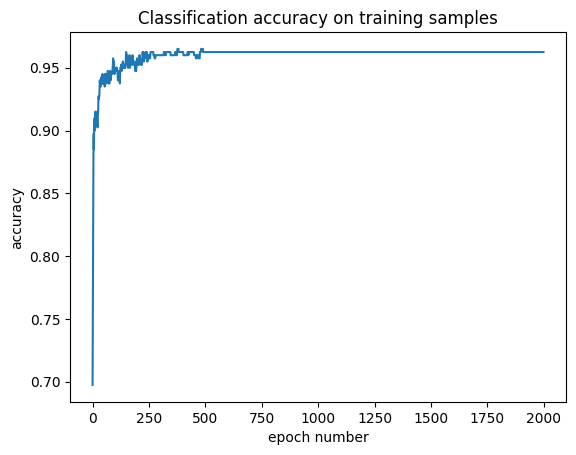

In [108]:
plt.figure()
plt.plot(accuracies)
plt.title('Classification accuracy on training samples')
plt.xlabel('epoch number')
plt.ylabel('accuracy')

Generate a grid of test samples.

Model testing on a grid of test samples to get the predicted classes.

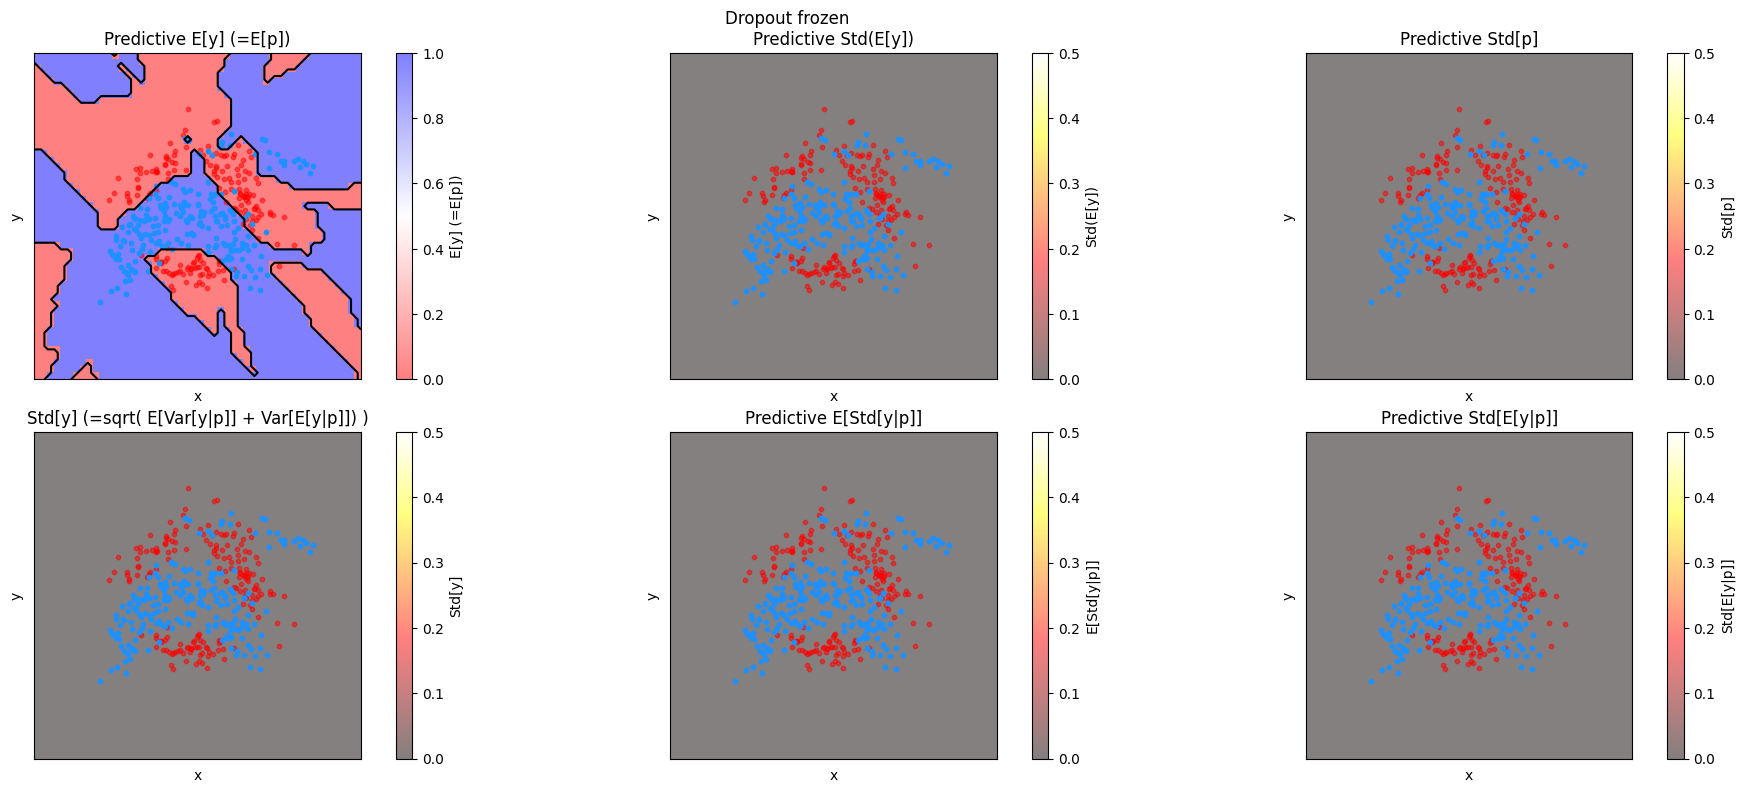

In [109]:
mlp.eval()

#Predict grid samples to classes without MC dropout
grid_outputs = F.softmax(mlp(grid_set), dim = -1)
grid_outputs = torch.squeeze(grid_outputs).detach().numpy()
grid_preds = np.argmax(grid_outputs, axis=1) #get predicted class

p_samples = grid_preds[None,...]  # add "sampling" dimension despite there's no sampling
plot_predictive_bernoulli(p_samples, title="Dropout frozen")

#### Model testing on a grid of test samples using MC dropout to get uncertainty estimates.

In [110]:
def sample_predictive_bernoulli_mlp(mlp, input_x, n_samples):
    # Function to allow dropout in model evaluation
    def apply_dropout(m):
        if type(m) == nn.Dropout:
            m.train()

    mlp.apply(apply_dropout) #allow dropout in evaluation mode

    #MC dropout samples
    MCoutputs = np.zeros((input_x.shape[0], 2, n_samples))
    for i in tqdm(range(n_samples)):
        grid_outputs = F.softmax(mlp(input_x), dim = -1)
        grid_outputs = torch.squeeze(grid_outputs).detach().numpy()
        MCoutputs[:,:,i] = grid_outputs
    p_samples = MCoutputs[:,1,:].T
    
    assert p_samples.shape==torch.Size([n_samples, input_x.shape[0]])
    return p_samples

100%|██████████| 123/123 [00:00<00:00, 176.26it/s]


p_samples.shape = (123, 2500)


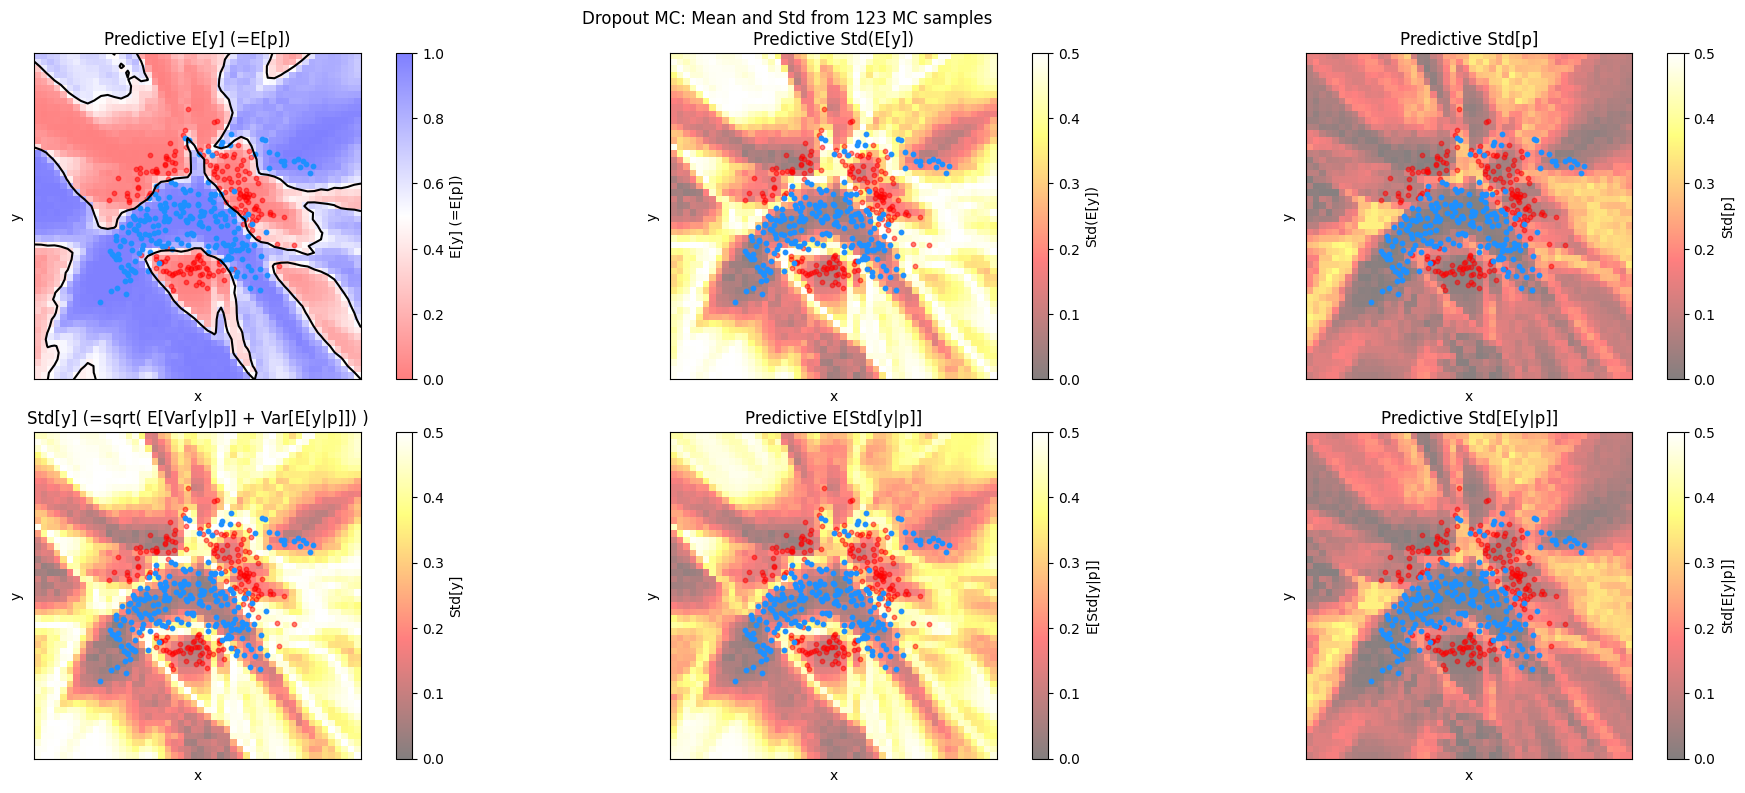

In [111]:
mlp_p_samples_for_eval = p_samples = sample_predictive_bernoulli_mlp(mlp, grid_set, plot_predictive_n_samples)
print(f"p_samples.shape = {p_samples.shape}")

plot_predictive_bernoulli(p_samples, title=f"Dropout MC: Mean and Std from {plot_predictive_n_samples} MC samples"); plt.show()

### Dropout NLL evaluation on training set

In [112]:
y = train_y.cpu().detach().numpy()
p = sample_predictive_bernoulli_mlp(mlp, train_x, plot_predictive_n_samples)
assert p.shape == torch.Size([plot_predictive_n_samples, y.shape[0]])
NLL = -(np.log(p + 1e-20)*(y) + np.log(1-p + 1e-20)*(1-y)).mean(0).sum()
print(f"Dropout (MC) total NLL (for sampled Bernoulli probabilites (p)) = {NLL}")

100%|██████████| 123/123 [00:00<00:00, 781.73it/s]

Dropout (MC) total NLL (for sampled Bernoulli probabilites (p)) = 60.77509360872456


In [113]:
mlp.eval()

#Predict grid samples to classes without MC dropout
grid_outputs = F.softmax(mlp(train_x), dim = -1)
grid_outputs = torch.squeeze(grid_outputs).detach().numpy()

p = grid_outputs[:, 1] 
assert p.shape == y.shape
NLL = -(np.log(p)*(y) + np.log(1-p)*(1-y)).sum()

report(f"Dropout (frozen) total NLL (for frozen Dropout) = {NLL}")

Dropout (frozen) total NLL (for frozen Dropout) = 44.20694047992765


## BNN

### BNN: Single-hidden-layer NN

In [114]:
class SingleHiddenLayerWideNNWithGaussianPriors(PyroModule):
    def __init__(self,   
                activation=None, 
                priors=None,
                config_json=None,
                net_width=1000, 
                in_dim=2, 
                out_dim=1
                ):
        super().__init__()
        self.in_dim = in_dim
        
        # Config:
        if config_json is None:
            config = {}
            
        else:
            try:
                config = import_export.load_parameters_from_json(config_json, net_width=net_width)
            except Exception as e:
                print(f"[SingleHiddenLayerWideNNWithGaussianPriors] WARNING: Failed to load parameters from json: {e}! ")

        # Activation:
        self.activation = activation or config.get("activation")
        if self.activation is None:
            raise ValueError("[SingleHiddenLayerWideNNWithGaussianPriors] "
                             "Activation must be passed as a parameter or loaded from a json file!")
        print(f"[SingleHiddenLayerWideNNWithGaussianPriors] Using activation = {self.activation}.")      
          
        if hasattr(self.activation, "named_parameters"):  # turn off gradients in the module
            [p.requires_grad_(False) for n, p in self.activation.named_parameters()]
        
        # Priors:
        priors = priors or config
        if priors is None:
            raise ValueError("[SingleHiddenLayerWideNNWithGaussianPriors] "
                             "Parameters must be passed or loaded from a json file!")
        print(f"[SingleHiddenLayerWideNNWithGaussianPriors] Loading priors from parameters object = {priors}.")        

        # Model:
        self.layer1 = PyroModule[nn.Linear](in_dim, net_width)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](net_width, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(priors["layer1.weight"].expand([net_width, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(priors["layer1.bias"].expand([net_width]).to_event(1))
        self.layer2.weight = PyroSample(priors["layer2.weight"].expand([out_dim, net_width]).to_event(2))
        self.layer2.bias = PyroSample(priors["layer2.bias"].expand([out_dim]).to_event(1))                
        
    def forward(self, x, y=None):
        x = x.reshape(-1, self.in_dim)
        x = self.layer1(x)
        with torch.no_grad():
            x = self.activation(x)
        mu = self.layer2(x).squeeze()
        
        # Likelihood model                   
        p = torch.sigmoid(mu)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Bernoulli(probs=p), obs=y)
            # obs = pyro.sample("obs", dist.RelaxedBernoulliStraightThrough(probs=p, temperature=torch.tensor(0.1)), obs=y)   
                     
        # Register p as a deterministic output
        pyro.deterministic("p", p)
        
        if y is not None:
            log_likelihood = dist.Bernoulli(probs=p).log_prob(y)
            pyro.deterministic("log_likelihood", log_likelihood)
    
        return p # TO CHECK ?#?@?@?! 

### BNN parameters

In [115]:
# Set Pyro random seed
pyro.set_rng_seed(41)

In [116]:
# Pretrained priors:

config_json = "../pretrained/train_priors_and_activations_Ann_1_5_Pgaussian_0s_S1_results.json"  


[20:30:25] {../train_priors_and_activations.py:219} INFO - Configuration: {'run_name': '../results/gp_vs_bnn_classification_test_banana_20240903202923/prior_fit', 'generator_width': 1000, 'bnn_width': 1000, 'loss_func': <function wasserstein_distance at 0x7f7be1565c10>, 'create_parameter_sampler': <function create_factorized_shared_gaussian_sampler_zero_loc at 0x7f7be15790d0>, 'activation': 'nnsilu_1_5', 'batch_size': 128, 'num_function_samples': 128, 'shuffle_xs_n_times': 1, 'freeze_training_grid': False, 'n_iterations': 101, 'lr': 0.01, 'report_every_n_iterations': 200, 'config_set_no': -111, 'test_grid_n_nodes': 512, 'final_evaluation_batch_size': 1024, 'final_evaluation_num_function_samples': 512, 'uniform_training_grid': False, 'final_evaluation_on_training_grid': False, 'random_seed': None, 'description': {}, 'force_recomputing': True, 'results_path': '../results/gp_vs_bnn_classification_test_banana_20240903202923/prior_fit_results.json', 'start_time': 1725388225.542473, 'input_n

Parsing priors=train


python/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
python/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
[20:30:27] {../train_priors_and_activations.py:148} INFO - loss = 70.238
[20:30:27] {../train_priors_and_activations.py:152} INFO - variational_params={'fc1.weight.scale': '0.60', 'fc1.bias.scale': '0.81', 'fc2.weight.scale': '1.66', 'fc2.bias.scale': '2.85'}
100%|██████████| 101/101 [04:06<00:00,  2.44s/it]
[20:34:32] {../train_priors_and_activations.py:279} INFO - training history:
     iteration       loss         eta
0            0  70.238205    2.341213
1            1  36.164482    5.721744
2            2  23.847054    8.242884
3            3  12.567412   10.576309
4            4   8.422421   13.044749
..         ...        ...         ...
96          96   3.463810  236.268687
97 

[SingleHiddenLayerWideNNWithGaussianPriors] Using activation = NNActivation(
  (activation): SiLU()
  (fci): Linear(in_features=1, out_features=5, bias=True)
  (fc): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
  )
  (fco): Linear(in_features=5, out_features=1, bias=True)
).
[SingleHiddenLayerWideNNWithGaussianPriors] Loading priors from parameters object = {'layer1.weight': Normal(loc: 0.0, scale: 0.5207616686820984), 'layer1.bias': Normal(loc: 0.0, scale: 0.6787156462669373), 'layer2.weight': Normal(loc: 0.0, scale: 4.903838634490967), 'layer2.bias': Normal(loc: 0.0, scale: 2.0579161643981934)}.
BNN: model = SingleHiddenLayerWideNNWithGaussianPriors(
  (activation): NNActivation(
    (activation): SiLU()
    (fci): Linear(in_features=1, out_features=5, bias=True)
    (fc): Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
    )
    (fco): Linear(in_features=5, out_features=1, bias=True)
  )
  (layer1): PyroLinear(in_features=2, out_featu

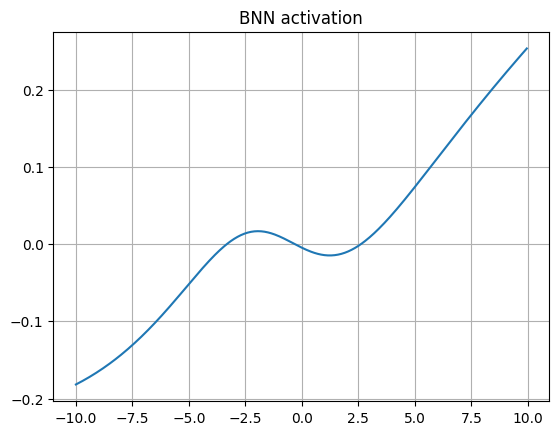

In [117]:
# Building model

print(f"Parsing priors={priors}")

if priors == "train":    
    fit = train_priors_and_activations(
        config_set_no=target_gp_config_set_no,
        bnn_width=bnn_net_width,
        input_n_dims=train_input_n_dims,
        n_iterations=train_n_iterations, 
        num_function_samples=train_num_function_samples,  
        batch_size=train_batch_size,  
        activation=train_activation, 
        run_name=results_prefix+"prior_fit",
        freeze_training_grid=False,
        final_evaluation_batch_size=512,
        final_evaluation_num_function_samples=512,
        uniform_training_grid=False,           
        force_recomputing=True,
        )
        
    bnn_model = SingleHiddenLayerWideNNWithGaussianPriors(
        net_width=bnn_net_width,
        priors=import_export.decode_gaussian_priors(fit["parameters"]["prior"], target_net_width=bnn_net_width),
        activation=import_export.decode_activation(fit["parameters"]["activation"]),
        )
    
elif priors == "pretrained":
    bnn_model = SingleHiddenLayerWideNNWithGaussianPriors(
        net_width=bnn_net_width,
        config_json=config_json,
        )
    
elif priors.startswith("pretrained_with_"):
    activation_name = priors.split("_")[-1]
    activation = activations.get_activation(activation_name)
    print(f"Retrieved activation = {activation}")
    
    bnn_model = SingleHiddenLayerWideNNWithGaussianPriors(
        net_width=bnn_net_width,
        config_json=config_json,
        activation = activation,
        )    
    
elif priors.startswith("normal_with_"):
    prior_parameters = {  # defaults which may be overwritten below
          "layer1.weight": dist.Normal(0., 1.),
          "layer1.bias": dist.Normal(0., 1.),
          "layer2.weight": dist.Normal(0., 1. / np.sqrt(bnn_net_width)),
          "layer2.bias": dist.Normal(0., 1.)                         
        } 
    
    activation_name = priors.split("_")[-1]
    activation = activations.get_activation(activation_name)
    print(f"Retrieved activation = {activation}")

    bnn_model = SingleHiddenLayerWideNNWithGaussianPriors(
        net_width=bnn_net_width,
        priors=prior_parameters,
        activation=activation, 
        )
    
elif priors.startswith("default_with_"):
    prior_parameters = {  # defaults which may be overwritten below
          "layer1.weight": dist.Normal(0., 1.),
          "layer1.bias": dist.Normal(0., 1.),
          "layer2.weight": dist.Normal(0., 1.),  # NOTE: enable overconfidence for ReLU !!!
          "layer2.bias": dist.Normal(0., 1.)                         
        } 
    
    activation_name = priors.split("_")[-1]
    activation = activations.get_activation(activation_name)
    print(f"Retrieved activation = {activation}")

    bnn_model = SingleHiddenLayerWideNNWithGaussianPriors(
        net_width=bnn_net_width,
        priors=prior_parameters,
        activation=activation, 
        )    
    
else:
    raise ValueError(f"Failed to interpret priors = {priors}!")    
    
print(f"BNN: model = {bnn_model}")
plt.plot(torch.arange(-10, 10, 0.05), bnn_model.activation(torch.arange(-10, 10, 0.05)))
plt.grid(True)
plt.title("BNN activation");

#### Sample from prior 

python/lib/python3.8/site-packages/pyro/primitives.py:443: UserWarning: fci.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
python/lib/python3.8/site-packages/pyro/primitives.py:443: UserWarning: fci.bias was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
python/lib/python3.8/site-packages/pyro/primitives.py:443: UserWarning: fc.0.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
python/lib/python3.8/site-packages/pyro/primitives.py:443: UserWarning: fc.0.bias was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
python/lib/python3.8/site-packages/pyro/primitives.py:443: UserWarning: fco.weight

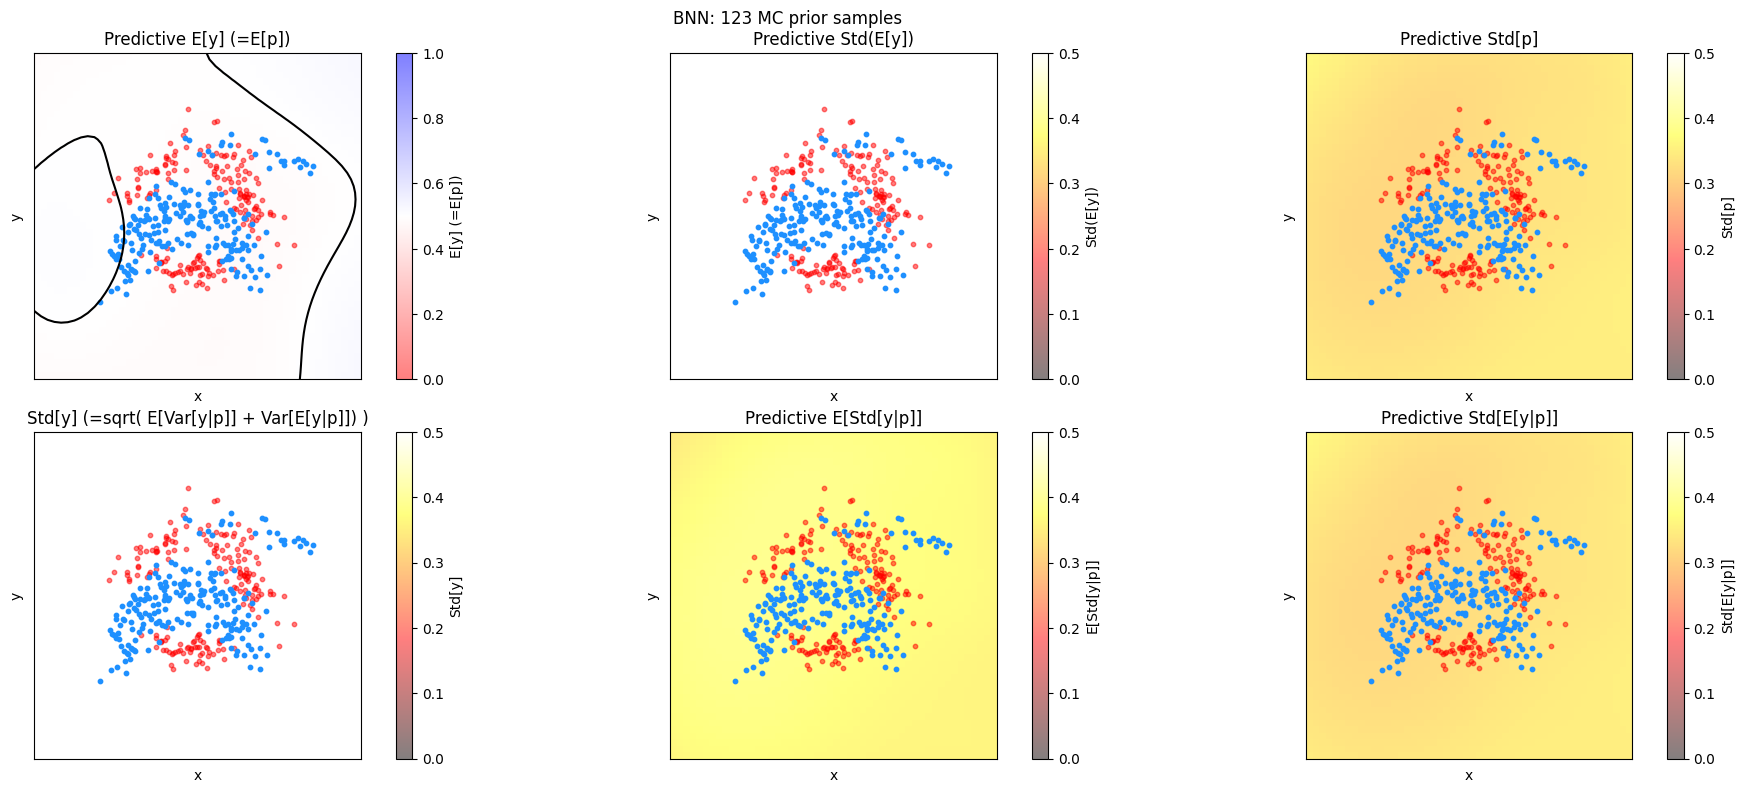

In [118]:
p_samples = torch.stack([bnn_model(grid_set) for _ in range(plot_predictive_n_samples)])

plot_predictive_bernoulli(p_samples, title=f"BNN: {plot_predictive_n_samples} MC prior samples"); plt.show()

### Posterior training and evaluation

In [119]:
# Define Hamiltonian Monte Carlo (HMC) kernel

# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(bnn_model, jit_compile=True)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get MC posterior samples
mcmc = MCMC(nuts_kernel, num_samples=MCMC_n_samples//MCMC_n_chains, num_chains=MCMC_n_chains) #, disable_validation=True)

# Run MCMC
mcmc.run(train_x, torch.tensor(train_y, dtype=torch.float))

# Print summary statistics
mcmc.summary(prob=0.8)  # This gives you the 80% credible interval by default

predictive = Predictive(model=bnn_model, posterior_samples=mcmc.get_samples())
preds = predictive(train_x, train_y.type(torch.float32))

report_metric("BNN posterior predictive log likelihood of the training data (mean)", preds["log_likelihood"].mean())
report_metric("BNN posterior predictive log likelihood of the training data (total)", preds["log_likelihood"].mean(0).sum())

/var/folders/hp/hs3z_y8d7jx9n5m6m4yqp3zm0000gp/T/ipykernel_73303/3587039660.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mcmc.run(train_x, torch.tensor(train_y, dtype=torch.float))
Warmup:   0%|          | 0/222 [00:00, ?it/s]python/lib/python3.8/site-packages/pyro/primitives.py:443: UserWarning: fci.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
python/lib/python3.8/site-packages/pyro/primitives.py:443: UserWarning: fci.bias was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
python/lib/python3.8/site-packages/pyro/primitives.py:443: UserWarning: fc.0.weight was not registered in the param store because requires_grad=False. You c


                         mean       std    median     10.0%     90.0%     n_eff     r_hat
     layer1.bias[0]      0.05      0.61      0.02     -0.61      0.90    190.67      1.00
     layer1.bias[1]      0.02      0.76     -0.01     -0.93      1.00     94.78      0.99
     layer1.bias[2]     -0.02      0.77     -0.08     -1.11      0.95    439.59      0.99
     layer1.bias[3]      0.04      0.76      0.04     -1.00      0.91    164.18      0.99
     layer1.bias[4]     -0.09      0.66     -0.10     -1.18      0.46    221.39      0.99
     layer1.bias[5]     -0.05      0.73     -0.07     -0.94      0.84     80.73      1.00
     layer1.bias[6]     -0.04      0.63     -0.09     -0.69      0.85    191.08      1.01
     layer1.bias[7]     -0.01      0.72      0.01     -0.90      0.83    247.29      0.99
     layer1.bias[8]     -0.06      0.69     -0.07     -0.98      0.70    129.12      1.00
     layer1.bias[9]      0.05      0.70      0.01     -0.68      1.09    236.48      0.99
    layer

BNN preds: grid_set.shape=torch.Size([2500, 2]) p.shape=torch.Size([111, 1, 2500]) obs=torch.Size([111, 2500])


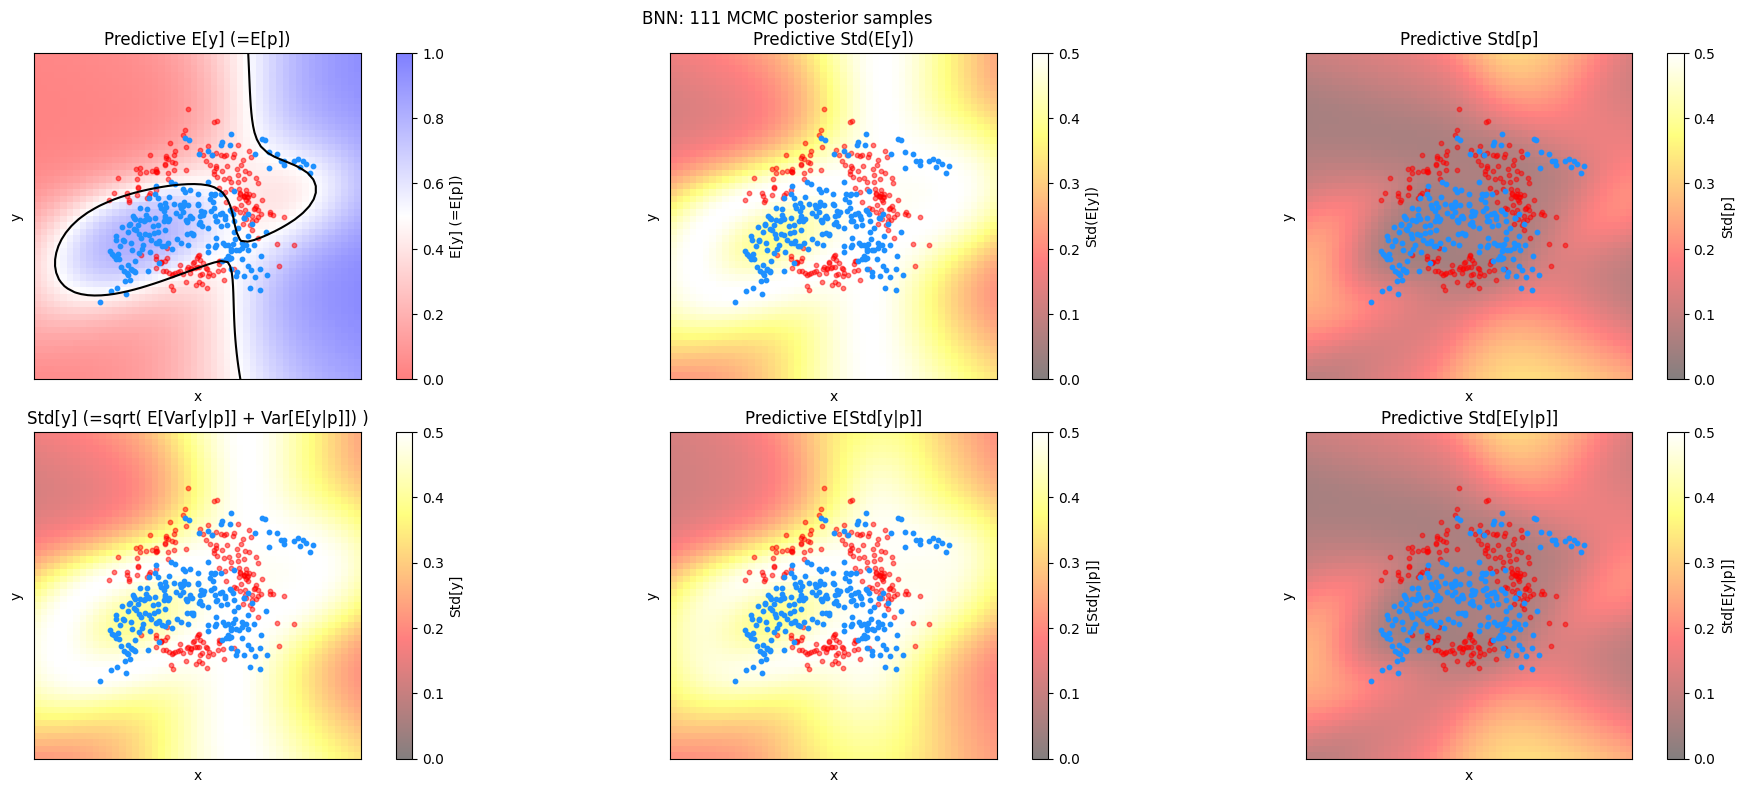

In [120]:
# p_values = torch.stack([bnn_model(grid_set) for _ in range(MC)])
preds = predictive(grid_set)
print(f"BNN preds: grid_set.shape={grid_set.shape} p.shape={preds['p'].shape} obs={preds['obs'].shape}")
bnn_p_samples_for_eval = p_samples = preds['p'][:,0,:]  # Get Bernoulli p values

MC = preds['p'].shape[0]
plot_predictive_bernoulli(p_samples, title=f"BNN: {MC} MCMC posterior samples"); plt.show()

In [121]:
preds = predictive(train_x)
y = train_y.cpu().detach().numpy()
p = preds['p'][:,0,:]  # Get Bernoulli p values
assert p.shape==torch.Size([MCMC_n_samples, y.shape[0]])

NLL = -(np.log(p + 1e-20)*(y) + np.log(1-p + 1e-20)*(1-y)).mean(0).sum()
print(f"BNN posterior total NLL = {NLL}")

python/lib/python3.8/site-packages/pyro/primitives.py:443: UserWarning: fci.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
python/lib/python3.8/site-packages/pyro/primitives.py:443: UserWarning: fci.bias was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
python/lib/python3.8/site-packages/pyro/primitives.py:443: UserWarning: fc.0.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
python/lib/python3.8/site-packages/pyro/primitives.py:443: UserWarning: fc.0.bias was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
python/lib/python3.8/site-packages/pyro/primitives.py:443: UserWarning: fco.weight

BNN posterior total NLL = 222.81751574344327


## Evaluation

In [122]:
mlp_p_samples_for_eval = torch.tensor(mlp_p_samples_for_eval, dtype=gp_p_samples_for_eval.dtype)

min_n_func_samples = min(bnn_p_samples_for_eval.shape[0], gp_p_samples_for_eval.shape[0], mlp_p_samples_for_eval.shape[0])
report(f"Final evaluation was performed on batch_size={min_n_func_samples} functions")

mlp_p_samples_for_eval = mlp_p_samples_for_eval[:min_n_func_samples,...]
bnn_p_samples_for_eval = bnn_p_samples_for_eval[:min_n_func_samples,...]
gp_p_samples_for_eval = gp_p_samples_for_eval[:min_n_func_samples,...]

bnn_metrics = metrics.compute_distribution_distances(bnn_p_samples_for_eval, gp_p_samples_for_eval)
mlp_metrics = metrics.compute_distribution_distances(mlp_p_samples_for_eval, gp_p_samples_for_eval)
cross_metrics1 = metrics.compute_distribution_distances(mlp_p_samples_for_eval, bnn_p_samples_for_eval)
cross_metrics2 = metrics.compute_distribution_distances(bnn_p_samples_for_eval, mlp_p_samples_for_eval)     

Final evaluation was performed on batch_size=111 functions


In [123]:
for metric_name in bnn_metrics.keys():
    print("=============")
    report_metric(f"BNN<-GP {metric_name}", bnn_metrics[metric_name])
    report_metric(f"MLP<-GP {metric_name}", mlp_metrics[metric_name])    
    report_metric(f"BNN<-MLP (BNN as ground truth) {metric_name}", cross_metrics1[metric_name])
    report_metric(f"BNN->MLP (MLP as ground truth) {metric_name}", cross_metrics2[metric_name])   

BNN 1-Wasserstein = 16.89942544645017
MLP 1-Wasserstein = 17.64750846656593
BNN<-MLP (BNN as ground truth) 1-Wasserstein = 22.12937832737828
BNN->MLP (MLP as ground truth) 1-Wasserstein = 22.12937827582833
BNN 2-Wasserstein = 16.939461484639036
MLP 2-Wasserstein = 17.648278039521042
BNN<-MLP (BNN as ground truth) 2-Wasserstein = 22.15686060528518
BNN->MLP (MLP as ground truth) 2-Wasserstein = 22.156860338502682
BNN Linear_MMD = 168.7832794189453
MLP Linear_MMD = 182.98837280273438
BNN<-MLP (BNN as ground truth) Linear_MMD = 369.9429016113281
BNN->MLP (MLP as ground truth) Linear_MMD = 369.9429016113281
BNN Poly_MMD = 230686.65625
MLP Poly_MMD = 411892.75
BNN<-MLP (BNN as ground truth) Poly_MMD = 708822.875
BNN->MLP (MLP as ground truth) Poly_MMD = 708822.8125
BNN RBF_MMD = 0.7230169773101807
MLP RBF_MMD = 0.6899652481079102
BNN<-MLP (BNN as ground truth) RBF_MMD = 1.031848430633545
BNN->MLP (MLP as ground truth) RBF_MMD = 1.0318481922149658
BNN Mean_MSE = 0.06740044057369232
MLP Mean_M

In [124]:
with open(results_prefix+'bnn_metrics.json', 'w') as fp:
    json.dump(bnn_metrics, fp)
with open(results_prefix+'mlp_metrics.json', 'w') as fp:
    json.dump(mlp_metrics, fp)
with open(results_prefix+'cross_metrics1.json', 'w') as fp:
    json.dump(cross_metrics1, fp)
with open(results_prefix+'cross_metrics2.json', 'w') as fp:
    json.dump(cross_metrics2, fp)            